In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

In [ ]:
ROWS = 512
COLS = 512
CHANNELS = 3
CLASSES = 2

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size_tr = 64
batch_size_val = 64
input_size = (512,512,3)

train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        featurewise_center=False,	# set input mean to 0 over dataset
        samplewise_center=False,	# set each sample mean to 0
        featurewise_std_normalization=False,	# divide inputs by std of dataset
        samplewise_std_normalization=False,	#divide each input by its std
        zca_whitening=False,	# apply ZCA whitening
        rotation_range=90,	# randomly roate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,	# randomly shift image horizontally (fraction of width)
        height_shift_range=0.1,	# randomly shift image vertically (fraction of height)
        horizontal_flip=True,	# randomly flip images horizontally
        vertical_flip=True	# randomly flip images vertically
        )

test_datagen = ImageDataGenerator()
                                  

train_generator = train_datagen.flow_from_directory(
        '/mydrive/trouts_split/train',  
        batch_size=batch_size_tr,
        shuffle=True,
        target_size=(512,512),
        class_mode='categorical')  

validation_generator = test_datagen.flow_from_directory(
        '/mydrive/trouts_split/validation',  
        batch_size=batch_size_val,
        target_size=(512,512),
        shuffle=True,
        class_mode='categorical')

Found 808 images belonging to 2 classes.
Found 201 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from pathlib import Path
from PIL import Image

height = width = 512 
batch_size_tr = 32
batch_size_val = 32
input_size = (512,512,3)

def read_pil_image(img_path, height, width):
        with open(img_path, 'rb') as f:
            return np.array(Image.open(f).convert('RGB').resize((512,512)))

def load_all_images(dataset_path, height, width, img_ext='jpg'):
    return np.array([read_pil_image(str(p), height, width) for p in 
                                    Path(dataset_path).rglob("*."+img_ext)]) 

train_datagen = ImageDataGenerator(
    #shear_range=0.,
    zoom_range=0.2,
    featurewise_center=True,	# set input mean to 0 over dataset
    samplewise_center=False,	# set each sample mean to 0
    featurewise_std_normalization=True,	# divide inputs by std of dataset
    samplewise_std_normalization=False,	#divide each input by its std
    zca_whitening=False,	# apply ZCA whitening
    rotation_range=90,	# randomly roate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,	# randomly shift image horizontally (fraction of width)
    height_shift_range=0.1,	# randomly shift image vertically (fraction of height)
    horizontal_flip=True,	# randomly flip images horizontally
    vertical_flip=True,	# randomly flip images vertically
    brightness_range = [0.3,0.9] # range for picking a brightness shift value from.
)
train_datagen.fit(load_all_images('/mydrive/trouts_split/train/', height, width))
validation_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        '/mydrive/trouts_split/train/',
        target_size=(height, width),
        batch_size=batch_size_tr,
        shuffle=True,
        class_mode='categorical',
        color_mode='rgb')

validation_generator = validation_datagen.flow_from_directory(
        '/mydrive/trouts_split/validation',  
        batch_size=batch_size_val,
        target_size=(height,width),
        shuffle=True,
        class_mode='categorical',
        color_mode='rgb')

In [ ]:
import os
import cv2
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout, GaussianNoise
from keras.callbacks import History, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger, Callback, LambdaCallback
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.utils import plot_model
from IPython.display import SVG
from keras.optimizers import Adam, RMSprop
from keras.utils.vis_utils import model_to_dot
import keras.backend as K
import tensorflow as tf

In [ ]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2 = filters

    # Save the input value. We'll need this later to add back to the main path. 
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (3, 3), strides = (1,1), padding = 'same', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (3, 3), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (3, 3), strides = (s,s),  padding='same',name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(3, 3), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)

    
    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F2, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [ ]:
def ResNet18(input_shape = (256, 256, 3), classes = 2):   
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    #X = GaussianNoise(0.01)(X_input)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    #X = convolutional_block(X, f = 3, filters = [64, 64], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64], stage=2, block='a')
    X = identity_block(X, 3, [64, 64], stage=2, block='b')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128], stage=3, block='b')


    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256], stage=4, block='b')


    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512], stage=5, block='b')

    # AVGPOOL.
    X = AveragePooling2D((2, 2), name='avg_pool')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(1024, activation='relu', name='fc1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Dropout(0.5)(X)
    #X = Dense(128, activation='relu', name='fc2', kernel_initializer = glorot_uniform(seed=0))(X)
    #X = Dropout(0.5)(X)

    
    X = Dense(classes, activation='softmax', name='fc5' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet18')

    return model

In [ ]:
model = ResNet18(input_shape = (ROWS, COLS, CHANNELS), classes = CLASSES)

In [ ]:
model.summary()

In [ ]:
csv_logger = CSVLogger('/mydrive/trouts_split/ResNet18_LR5_1FC_1024_droupout_point5_v1.csv',append=True)

In [ ]:
model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
rms = RMSprop( lr=1e-3,
    momentum=0.9
    #epsilon=1e-05,
)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=rms,
              metrics=['accuracy'])

In [ ]:
import sys
global best_val_acc
global best_val_loss 

best_val_loss = sys.float_info.max
best_val_acc = 0

#Saving the best model
checkpointer = ModelCheckpoint(filepath="/mydrive/trouts_split/ResNet18_best_weights_LR5_1FC_1024_droupout_point5_v1.hdf5", 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_best_only=True)

#Stop training when a monitored metric has stopped improving
early_stopping = EarlyStopping(monitor='val_loss', patience=200)

def saveModel(epoch,logs):
  global best_val_loss
  global best_val_acc
  val_accuracy = logs['val_accuracy']
  val_loss = logs['val_loss']

  if val_accuracy > best_val_acc:
    best_val_acc = val_accuracy
    best_val_loss = val_loss
    model.save("/mydrive/trouts_split/ResNet18_best_weights_LR5_1FC_1024_droupout_point5_v1.hdf5")
  elif val_accuracy == best_val_acc:
    if val_loss < best_val_loss:
      best_val_loss=val_loss
      model.save("/mydrive/trouts_split/ResNet18_best_weights_LR5_1FC_1024_droupout_point5_v1.hdf5")




Lambdacallbacks = [LambdaCallback(on_epoch_end=saveModel)]


#Dynamically varying the LR
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.01,
                              patience=3, min_lr=5e-6)

In [ ]:
history = model.fit(train_generator, 
                    validation_data=validation_generator, 
                    epochs = 200, 
                    initial_epoch=150, 
                    callbacks=[csv_logger, Lambdacallbacks, reduce_lr])

Epoch 151/200
13/13 [==============================] - 812s 63s/step - loss: 0.4222 - accuracy: 0.8218 - val_loss: 0.5342 - val_accuracy: 0.7711
Epoch 152/200
13/13 [==============================] - 273s 21s/step - loss: 0.3078 - accuracy: 0.8886 - val_loss: 0.9948 - val_accuracy: 0.7214
Epoch 153/200
13/13 [==============================] - 267s 21s/step - loss: 0.2818 - accuracy: 0.8738 - val_loss: 0.6039 - val_accuracy: 0.8010
Epoch 154/200
13/13 [==============================] - 269s 21s/step - loss: 0.2572 - accuracy: 0.9158 - val_loss: 1.2744 - val_accuracy: 0.6766
Epoch 155/200
13/13 [==============================] - 266s 21s/step - loss: 0.2548 - accuracy: 0.8936 - val_loss: 0.7404 - val_accuracy: 0.7363
Epoch 156/200
13/13 [==============================] - 266s 21s/step - loss: 0.2302 - accuracy: 0.9134 - val_loss: 0.4101 - val_accuracy: 0.8358
Epoch 157/200
13/13 [==============================] - 268s 21s/step - loss: 0.2415 - accuracy: 0.9097 - val_loss: 0.5776 - val_ac

In [ ]:
import pandas as pd

df = pd.read_csv('/mydrive/trouts_split/ResNet18_LR5_1FC_512_droupout_point5_v1.csv')

history = df.to_dict(orient='list')

In [ ]:
datagen = ImageDataGenerator()
test_generator = datagen.flow_from_directory(
        '/mydrive/trouts_split/test',  
        batch_size=32,
        target_size=(512,512),
        shuffle=True,
        class_mode='categorical')

Found 253 images belonging to 2 classes.


In [ ]:
model.evaluate(test_generator)

8/8 [==============================] - 190s 25s/step - loss: 0.4969 - accuracy: 0.8573


[0.44563788175582886, 0.8735178112983704]

In [ ]:
#saving the weights
model.save_weights("/mydrive/trouts_split/ResNet18_weights_LR5_300_Epochs_100_v1.h5")

In [ ]:
model.load_weights("/mydrive/trouts_split/ResNet18_best_weights_trouts_1FC_1024_point5_LR5_150_Epochs_87_v1.h5")

In [ ]:
import matplotlib.pyplot as plt

def append_history(history, h):
     '''
	This function appends the statistics over epochs
     '''
     try:
       history.history['loss'] = history.history['loss'] + h.history['loss']
       history.history['val_loss'] = history.history['val_loss'] + h.history['val_loss']
       history.history['accuracy'] = history.history['accuracy'] + h.history['accuracy']
       history.history['val_accuracy'] = history.history['val_accuracy'] + h.history['val_accuracy']
     except:
       history = h
                
     return history
            

def unfreeze_layer_onwards(model, layer_name):
    '''
        This layer unfreezes all layers beyond layer_name
    '''
    trainable = False
    for layer in model.layers:
        try:
            if layer.name == layer_name:
                trainable = True
            layer.trainable = trainable
        except:
            continue
    
    return model
            

def plot_performance(history):
    '''
	This function plots the train & test accuracy, loss plots
    '''
        
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    #plt.axis([0, 2000, 0.2, 0.8])
    plt.title('Accuracy v/s Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left') 

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    #plt.axis([0, 2000, 0,1])
    plt.title('Loss v/s Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left') 

    plt.tight_layout()
    plt.show()

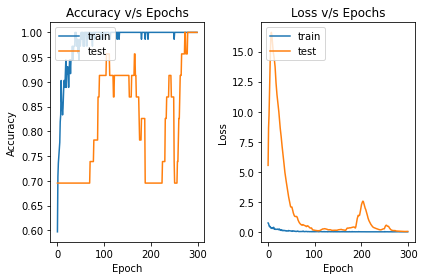

In [ ]:
plot_performance(history)

In [ ]:
np.save('/mydrive/trouts_split/my_history_ResNet_512x512_96_.npy',history.history)

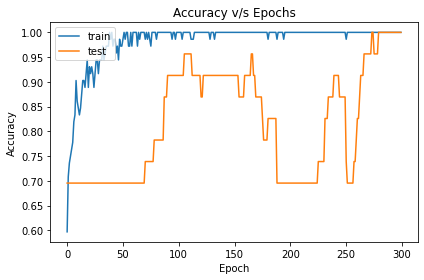

In [ ]:

plt.plot(history.history['accuracy'])

plt.plot(history.history['val_accuracy'])
#plt.axis([0, 200, 0.2, 0.8])
plt.title('Accuracy v/s Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left') 

plt.tight_layout()
plt.show()

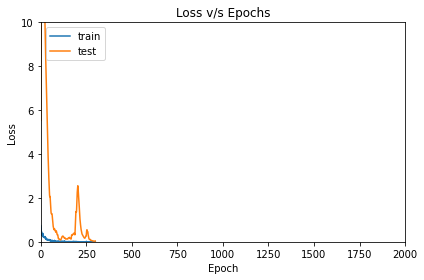

In [ ]:


plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])
plt.axis([0, 2000, 0,10])
plt.title('Loss v/s Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
plot_model(model, to_file='/mydrive/trouts_split/model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
n=200
history.history['accuracy'] = np.convolve(history.history['accuracy'], np.ones((n,)) / n, mode = "valid")
history.history['val_accuracy'] = np.convolve(history.history['val_accuracy'], np.ones((n,)) / n, mode = "valid")

history.history['val_loss'] = np.convolve(history.history['val_loss'], np.ones((n,)) / n, mode = "valid")
history.history['loss'] = np.convolve(history.history['loss'], np.ones((n,)) / n, mode = "valid")

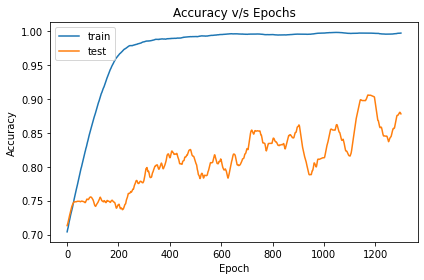

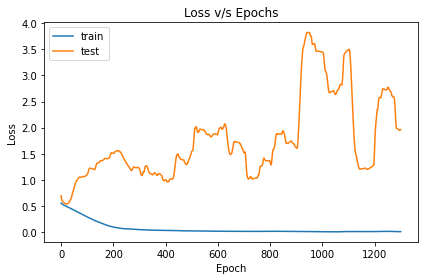

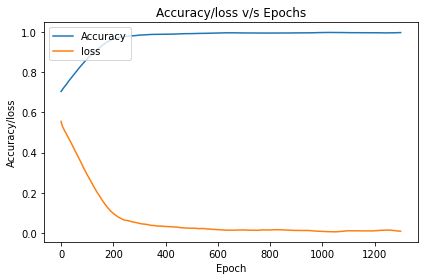

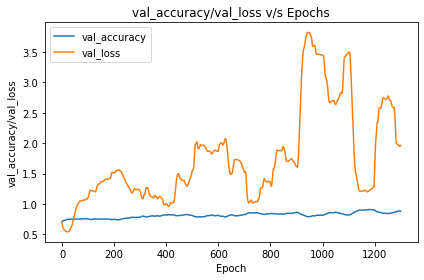

In [ ]:


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.axis([0, 200, 0.2, 0.8])
plt.title('Accuracy v/s Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left') 

plt.tight_layout()
plt.show()



plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])
#plt.axis([0, 200, 0,1])
plt.title('Loss v/s Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()



plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
#plt.axis([0, 200, 0.2, 0.8])
plt.title('Accuracy/loss v/s Epochs')
plt.ylabel('Accuracy/loss')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'loss'], loc='upper left') 

plt.tight_layout()
plt.show()

plt.plot(history.history['val_accuracy'])

plt.plot(history.history['val_loss'])
#plt.axis([0, 200, 0,1])
plt.title('val_accuracy/val_loss v/s Epochs')
plt.ylabel('val_accuracy/val_loss')
plt.xlabel('Epoch')
plt.legend(['val_accuracy', 'val_loss'], loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
datagen = ImageDataGenerator()
test_generator = datagen.flow_from_directory(
        '/mydrive/trouts_split/test',  
        batch_size=32,
        target_size=(256,256),
        shuffle=True,
        class_mode='categorical')

Found 28 images belonging to 2 classes.


In [ ]:
model.evaluate(test_generator)

1/1 [==============================] - 0s 2ms/step - loss: 0.6943 - accuracy: 0.8571


[0.6943143010139465, 0.8571428656578064]